In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import weaviate
from tqdm import tqdm

# --- Configuration ---
# Directories and files
DATA_DIR = '../data/'
METADATA_FILE = os.path.join(DATA_DIR, 'styles.csv')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')

# Weaviate connection
WEAVIATE_URL = "http://localhost:8080"

# Model for embedding
# We use CLIP, a powerful model from OpenAI for image and text.
MODEL_NAME = "openai/clip-vit-base-patch32"

# Check if a GPU is available for faster processing
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load metadata
df = pd.read_csv(METADATA_FILE, on_bad_lines='skip')

# --- NEW: ADD THE IMAGE PATH TO THE MAIN DATAFRAME ---
df['image_path'] = df['id'].apply(lambda x: os.path.join(IMAGE_DIR, str(x) + '.jpg'))

# --- NEW: Filter out missing images from the main DataFrame ---
# This also acts as a basic cleaning step.
original_len = len(df)
df = df[df['image_path'].apply(os.path.exists)]
print(f"Filtered out {original_len - len(df)} missing images.")
print(f"Working with {len(df)} total images.")


# For development, let's work with a smaller sample first.
sample_df = df.sample(n=1000, random_state=42)
print(f"Created a sample of {len(sample_df)} images for indexing.")

Filtered out 5 missing images.
Working with 44419 total images.
Created a sample of 1000 images for indexing.


In [3]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def get_image_embedding(image_path):
    """
    Takes an image file path, opens the image, processes it,
    and returns its vector embedding.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        # The processor prepares the image for the model
        inputs = processor(images=image, return_tensors="pt").to(device)
        # We get the image features (the embedding) from the model
        with torch.no_grad(): # Important: disable gradient calculation for inference
            embedding = model.get_image_features(**inputs)
        # Normalize the embedding and convert to a simple list
        embedding /= embedding.norm(dim=-1, keepdim=True)
        return embedding.cpu().numpy().tolist()[0]
    except Exception as e:
        # If an image is broken or can't be opened, we return None
        print(f"Error processing image {image_path}: {e}")
        return None

# Test it on one image
test_embedding = get_image_embedding(sample_df['image_path'].iloc[0])
print(f"Successfully generated an embedding of size: {len(test_embedding)}")

Successfully generated an embedding of size: 512


In [5]:
# v4 Client Import and Connection
import weaviate
import weaviate.classes.config as wvcc

# Connect to our local Weaviate instance using the v4 client
client = weaviate.connect_to_local()

# Define the "collection" (v4 term for "class")
collection_name = "StyleSeekerImage"

# Clean up previous attempts by deleting the collection if it exists
if client.collections.exists(collection_name):
    client.collections.delete(collection_name)

# Create the new collection
client.collections.create(
    name=collection_name,
    description="Fashion product images for visual search.",
    
    # In v4, we define properties within a properties list
    properties=[
        wvcc.Property(
            name="image_path",
            data_type=wvcc.DataType.TEXT, # Use TEXT for string
            description="The file path of the image.",
        ),
        wvcc.Property(
            name="product_name",
            data_type=wvcc.DataType.TEXT,
            description="The display name of the product.",
        ),
    ],
    
    # This tells Weaviate we are providing our own vectors.
    # It's the equivalent of vectorizer: "none" in v3.
    vectorizer_config=wvcc.Configure.Vectorizer.none()
)

print(f"Collection '{collection_name}' created successfully.")

# Close the client connection when done with schema changes
# We will reopen it for batch import
client.close()

Collection 'StyleSeekerImage' created successfully.


C:\Users\Mega-PC\OneDrive\Desktop\styleseeker\venv\Lib\site-packages\weaviate\warnings.py:196: DeprecationWarning: Dep024: You are using the `vectorizer_config` argument in `collection.config.create()`, which is deprecated.
            Use the `vector_config` argument instead.
            
  warnings.warn(


In [6]:
# Re-connect to Weaviate for batch operations
client = weaviate.connect_to_local()

# Get a reference to our collection
style_seeker_collection = client.collections.get(collection_name)

print("Starting data indexing with v4 client...")

# Use the collection's batch context manager for efficient importing
with style_seeker_collection.batch.dynamic() as batch:
    # Use tqdm for a progress bar
    for index, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):
        embedding = get_image_embedding(row['image_path'])
        
        # If the embedding was successful (image wasn't broken)
        if embedding:
            # The data object is now a dictionary of properties
            properties = {
                "image_path": row['image_path'],
                "product_name": row['productDisplayName']
            }
            
            # Add the object to the batch
            batch.add_object(
                properties=properties,
                vector=embedding # Provide our custom vector here
            )

print(f"Data indexing complete. Imported {len(style_seeker_collection)} objects.")

# The context manager (`with ...`) handles flushing the batch automatically.
client.close()

Starting data indexing with v4 client...


100%|███████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.53it/s]


Data indexing complete. Imported 1000 objects.


--- Query Image ---
Tantra Unisex Printed Red Tshirts


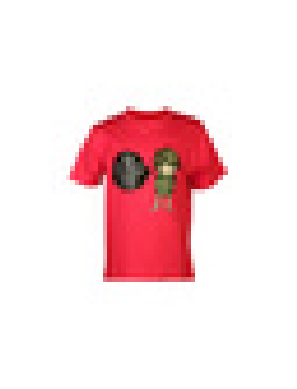


--- Search Results ---

Tantra Unisex Printed Red Tshirts


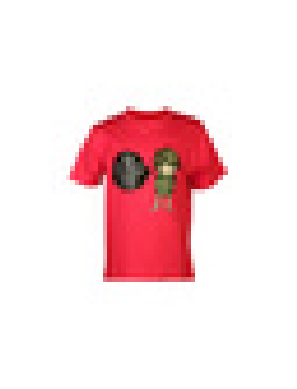

Tantra Kid's Unisex Stop Turqoise Kidswear


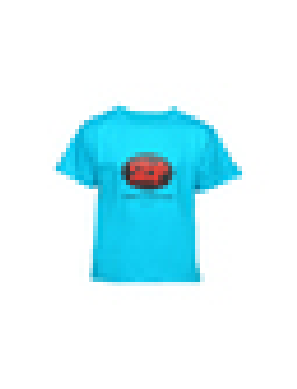

Palm Tree Boys Printed Green T-shirt


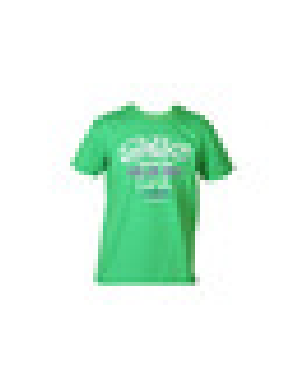

Doodle Girl's Tonight Night Rock Yellow Pink Kidswear


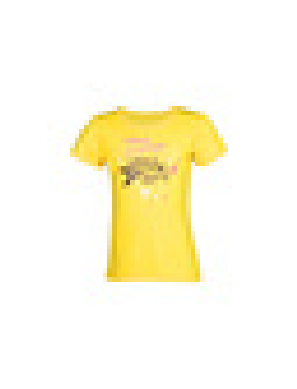

Gini and Jony Boys Rodeo White T-shirt


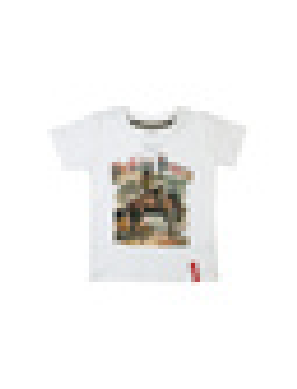

In [9]:
# Re-connect to Weaviate to perform a query
client = weaviate.connect_to_local()

# Get our collection
style_seeker_collection = client.collections.get(collection_name)

# Take a random image from our sample to use as a query.
query_image_path = sample_df[sample_df['productDisplayName'].str.contains("Tshirt", na=False)]['image_path'].iloc[0]

# Generate the embedding for our query image
query_vector = get_image_embedding(query_image_path)

# Perform the search
response = style_seeker_collection.query.near_vector(
    near_vector=query_vector,
    limit=5
)

# --- Print the results (Cleaned up version) ---
print("--- Query Image ---")
query_info = df[df['image_path'] == query_image_path]['productDisplayName'].values[0]
print(query_info)

# Use 'with' to ensure the image file is closed automatically
with Image.open(query_image_path) as img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

print("\n--- Search Results ---\n")
for item in response.objects:
    print(item.properties['product_name'])
    
    # Use 'with' for the result images as well
    with Image.open(item.properties['image_path']) as img:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# IMPORTANT: Close the database connection at the end of our work
client.close()